### Importing Necessary Packages

In [1]:
import pandas as pd
import numpy as np
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import graphviz
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\John Zhang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Reading In-Line JSON File

In [2]:
contents = open(r'transactions.txt', "r").read() 
data = [json.loads(str(item)) for item in contents.strip().split('\n')]
df = pd.DataFrame(data)

In [3]:
print('There are ', df.shape[0], 'transactions and', df.shape[1] , 'features in the data')

There are  786363 transactions and 29 features in the data


##### Replacing white space with Python Nan Values

In [4]:
df = df.apply(lambda x: x.str.strip() if isinstance(x, str) else x).replace('', np.nan)

In [5]:
df['isFraud'].value_counts()

False    773946
True      12417
Name: isFraud, dtype: int64

In [6]:
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing

accountNumber                 0.000000
customerId                    0.000000
creditLimit                   0.000000
availableMoney                0.000000
transactionDateTime           0.000000
transactionAmount             0.000000
merchantName                  0.000000
acqCountry                    0.580139
merchantCountryCode           0.092069
posEntryMode                  0.515538
posConditionCode              0.052012
merchantCategoryCode          0.000000
currentExpDate                0.000000
accountOpenDate               0.000000
dateOfLastAddressChange       0.000000
cardCVV                       0.000000
enteredCVV                    0.000000
cardLast4Digits               0.000000
transactionType               0.088763
echoBuffer                  100.000000
currentBalance                0.000000
merchantCity                100.000000
merchantState               100.000000
merchantZip                 100.000000
cardPresent                   0.000000
posOnPremises            

##### Dropping all columns that have 100 percent missing values, these are not conducive to learning or analysis

In [7]:
df.drop(['echoBuffer','merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'], axis=1, inplace=True)
df.isnull().sum()
df = df.reset_index(drop=True)

#### Remaining Columns

In [8]:
print(df.columns.tolist())

['accountNumber', 'customerId', 'creditLimit', 'availableMoney', 'transactionDateTime', 'transactionAmount', 'merchantName', 'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'merchantCategoryCode', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits', 'transactionType', 'currentBalance', 'cardPresent', 'expirationDateKeyInMatch', 'isFraud']


In [9]:
df.describe(include = 'all')

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
count,786363,786363,786363.000000,786363.000000,786363,786363.000000,786363,781801,785639,782309,...,786363,786363,786363,786363,786363,785665,786363.000000,786363,786363,786363
unique,5000,5000,NaN,NaN,776637,NaN,2490,4,4,5,...,1820,2184,899,976,5246,3,NaN,2,2,2
top,380680241,380680241,NaN,NaN,2016-12-25T14:04:15,NaN,Uber,US,US,05,...,2014-06-21,2016-03-15,869,869,593,PURCHASE,NaN,False,False,False
freq,32850,32850,NaN,NaN,4,NaN,25613,774709,778511,315035,...,33623,3819,33749,33424,32946,745193,NaN,433495,785320,773946
mean,NaN,NaN,10759.464459,6250.725369,NaN,136.985791,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4508.739089,NaN,NaN,NaN
std,NaN,NaN,11636.174890,8880.783989,NaN,147.725569,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6457.442068,NaN,NaN,NaN
min,NaN,NaN,250.000000,-1005.630000,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
25%,NaN,NaN,5000.000000,1077.420000,NaN,33.650000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,689.910000,NaN,NaN,NaN
50%,NaN,NaN,7500.000000,3184.860000,NaN,87.900000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2451.760000,NaN,NaN,NaN
75%,NaN,NaN,15000.000000,7500.000000,NaN,191.480000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5291.095000,NaN,NaN,NaN


#### Question 2

In [10]:
#Describing our column transaction amount
df['transactionAmount'].describe(percentiles = [0.25,0.99])

count    786363.000000
mean        136.985791
std         147.725569
min           0.000000
25%          33.650000
50%          87.900000
99%         675.630400
max        2011.540000
Name: transactionAmount, dtype: float64

<AxesSubplot:ylabel='Frequency'>

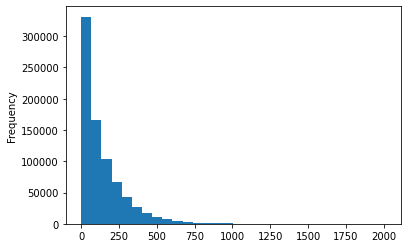

In [11]:
df['transactionAmount'].plot.hist(bins = 30)

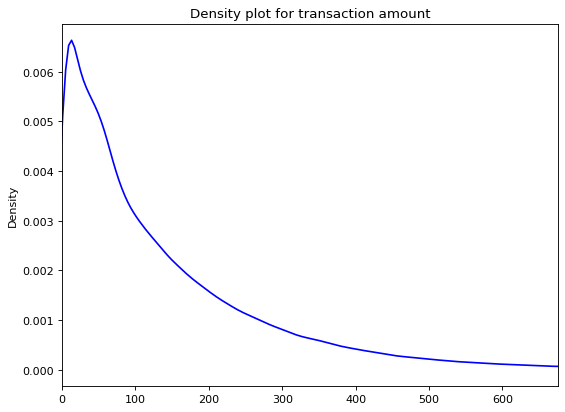

In [12]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
df.transactionAmount.plot.density(color='blue')
plt.title('Density plot for transaction amount')
plt.xlim([0, 675.63])
plt.show()

### Question 3

In [13]:
from datetime import datetime
from datetime import datetime, timedelta
df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'], infer_datetime_format=True) 
transaction_data = df

In [14]:
transaction_data['transactionType'].value_counts()

PURCHASE                745193
REVERSAL                 20303
ADDRESS_VERIFICATION     20169
Name: transactionType, dtype: int64

### Methodology: To find the reversal transactions I make a few assumptions about the process of reversal.
1. For every purchase in our transaction type column there should be a reversal
2. If it is a reversed transaction then the balance after reversal should be higher than of the original purchase.
3. at least one of the transaction times will be earlier than the other transaction time if it is reversed.
4. Reversed transactions should be the same amount as the original purchase
 
Following this logic, we first need to subset a dataframe to find where 'accountNumber', 'customerId', 'transactionAmount', 'merchantName' show up more than once, as every reversal should have these keys in common with its original purchase. Following finding the duplicate transactions we split the data into two groups: purchases and reversals so that when we inner join the two datasets we should have the common transactions that are the original purchase and the subsequent reversal of purchase. Then I check to see the condition that if the balance is higher after reversal and the transaction date of original purchase is before the date of the reverse



In [15]:
duplicated_trans = transaction_data[transaction_data.duplicated(['accountNumber', 'customerId', 'transactionAmount', 'merchantName'], keep=False)]

In [16]:
purchases = transaction_data[transaction_data['transactionType'] =="PURCHASE"]
reversals = transaction_data[transaction_data['transactionType'] =="REVERSAL"]
duplicated_trans.sort_values(['merchantName','transactionAmount','transactionType'])


,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
713743,633416049,633416049,5000.0,252.33,2016-03-13 01:06:47,0.00,1st BBQ,US,US,09,...,2013-10-06,2013-10-06,233,233,3149,ADDRESS_VERIFICATION,4747.67,False,False,False
713901,633416049,633416049,5000.0,2268.18,2016-12-03 20:15:01,0.00,1st BBQ,US,US,05,...,2013-10-06,2016-10-17,233,233,3149,ADDRESS_VERIFICATION,2731.82,False,False,False
735751,794946168,794946168,1000.0,292.91,2016-06-04 19:14:40,13.15,1st BBQ,US,US,05,...,2015-12-29,2015-12-29,571,571,8821,PURCHASE,707.09,True,False,False
735752,794946168,794946168,1000.0,279.76,2016-06-04 19:15:51,13.15,1st BBQ,US,US,05,...,2015-12-29,2015-12-29,571,571,8821,REVERSAL,720.24,True,False,False
438830,722406547,722406547,7500.0,6080.59,2016-09-04 03:53:58,13.20,1st BBQ,US,US,05,...,2010-02-08,2016-07-12,640,640,2326,PURCHASE,1419.41,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750302,405648828,405648828,7500.0,3021.47,2016-09-29 21:56:59,148.88,williamssonoma.com,US,US,05,...,2013-01-15,2013-01-15,951,951,9454,REVERSAL,4478.53,True,False,False
606705,599847715,599847715,2500.0,725.88,2016-02-15 06:44:12,246.42,williamssonoma.com,CAN,CAN,02,...,2014-04-03,2016-01-20,243,243,9104,PURCHASE,1774.12,True,False,False
606706,599847715,599847715,2500.0,479.46,2016-02-15 06:46:06,246.42,williamssonoma.com,CAN,CAN,02,...,2014-04-03,2016-01-20,243,243,9104,REVERSAL,2020.54,True,False,False
683285,640419026,640419026,50000.0,36337.30,2016-07-13 10:21:06,257.56,williamssonoma.com,NaN,US,09,...,2015-05-19,2015-05-19,769,769,7003,PURCHASE,13662.70,True,False,False


In [17]:
reversal_df = pd.merge(purchases,reversals, how = 'inner' , on = ['accountNumber','customerId','merchantName','transactionAmount'], validate='many_to_many')
reversal_df.shape

(18143, 42)

In [18]:
reversal_df = reversal_df[(reversal_df.currentBalance_y > reversal_df.currentBalance_x) | (reversal_df.transactionDateTime_x  < reversal_df.transactionDateTime_y)]

In [19]:
multi_swipes = purchases[purchases.duplicated(['accountNumber', 'customerId', 'transactionAmount', 'merchantName'], keep=False)]
multi_swipes.sort_values(['merchantName','transactionAmount']).head(5)


,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
232563,895803188,895803188,7500.0,6202.32,2016-03-07 18:06:31,22.09,1st BBQ,US,US,05,...,2013-01-26,2013-01-26,944,944,8107,PURCHASE,1297.68,True,False,False
232564,895803188,895803188,7500.0,6180.23,2016-03-07 18:07:56,22.09,1st BBQ,US,US,05,...,2013-01-26,2013-01-26,944,944,8107,PURCHASE,1319.77,True,False,False
232565,895803188,895803188,7500.0,6158.14,2016-03-07 18:09:40,22.09,1st BBQ,US,US,05,...,2013-01-26,2013-01-26,944,944,8107,PURCHASE,1341.86,True,False,False
640752,640316790,640316790,2500.0,2500.00,2016-03-12 04:58:58,47.96,1st BBQ,US,US,05,...,2015-10-09,2015-10-09,544,544,0000,PURCHASE,0.00,True,False,False
640753,640316790,640316790,2500.0,2452.04,2016-03-12 05:01:53,47.96,1st BBQ,US,US,05,...,2015-10-09,2015-10-09,544,544,0000,PURCHASE,47.96,True,False,False


### Methodology: To find the Multiswipe transactions I make a few assumptions about the process of multiswipe transactions.
1. Transactions should happen within a short time period of each other, I am assuming at the most a few minutes as multiswipes happen consecutively
2. Multiswipe transactions should have the same transaction amount for each consecutive transaction.
 
Following this logic, we first create the data from the purchases dataset that could potentially have all the multiswipes. Then we sort this data by their merchant name and transaction amount, as multiswipes would have these keys in common.
Following this we then need to calculate the time span between the multi swipe purchases. We use df.diff() for this purpose as it finds the difference of objects over the axis, and converts this column to seconds so we can analyze it further. 
I assume that multi-swiped transactions happen within 5 minutes and consider the first multiswipe transaction to be a valid purchase and the following subsequent transactions to be multi swiped.


In [20]:
multi_swipes['time_diff'] = multi_swipes[('transactionDateTime')].diff(1).dt.total_seconds().apply(lambda x: x / 3600)

C:\Users\John Zhang\AppData\Local\Temp\ipykernel_11820\734702334.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multi_swipes['time_diff'] = multi_swipes[('transactionDateTime')].diff(1).dt.total_seconds().apply(lambda x: x / 3600)


In [21]:
multi_swipes.groupby(['accountNumber', 'customerId', 'merchantName', 'transactionAmount'])
multi_swipes = multi_swipes[multi_swipes['time_diff'].between(0,300)]


In [22]:
'''
By applying this lambda function we are able to filter out the first "valid" purchase for each group of multiswipe transactions. Therefore the remaining rows are the erroneous swipes.
'''
multi_swipes = multi_swipes.apply(lambda group: group.iloc[1:]) 

In [23]:
print('Number of reverse Transactions', len(reversal_df) , ' the sum of the reverse transactions is',reversal_df['transactionAmount'].sum() )

Number of reverse Transactions 18081  the sum of the reverse transactions is 2709243.5


In [24]:
print('Number of multiswiped Transactions', len(multi_swipes) , ' the sum of the multiswiped Transactions is',multi_swipes['transactionAmount'].sum() )

Number of multiswiped Transactions 33682  the sum of the multiswiped Transactions is 2579905.05


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

reversal_df['time_difference'] = (reversal_df.transactionDateTime_y - reversal_df.transactionDateTime_x).apply(lambda x: x / np.timedelta64(1,'D'))

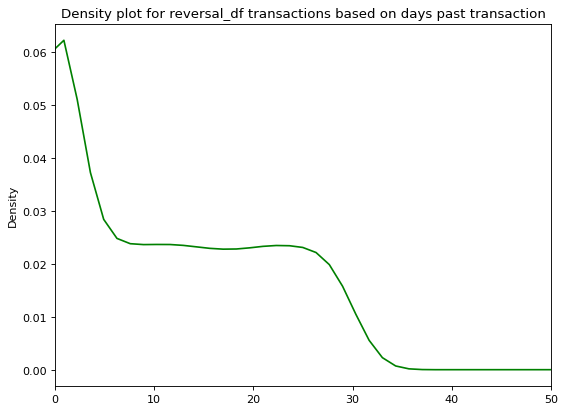

In [26]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
reversal_df.time_difference.plot.density(color='green')
plt.title('Density plot for reversal_df transactions based on days past transaction')
plt.xlim([0, 50])
plt.show()

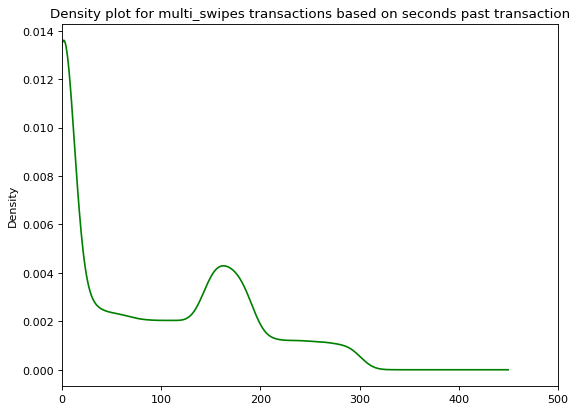

In [27]:
figure(figsize=(8, 6), dpi=80)
multi_swipes.time_diff.plot.density(color='green')
plt.title('Density plot for multi_swipes transactions based on seconds past transaction')
plt.xlim([0, 500])
plt.show()

### Observations
Because I based identifying reversal and multiswipe transactions based on their transaction dates, I created the two density plots visualizing the time span between both events. From these graphs we see that most reversal transactions take place between 0 - 8 days. Comparatively most multiswipe transactions happen within 0- 4 minutes (0 -240 seconds). This makes sense as multiswipe transactions are by definition consecutive purchases registered by the vendor in successive order.


<AxesSubplot:>

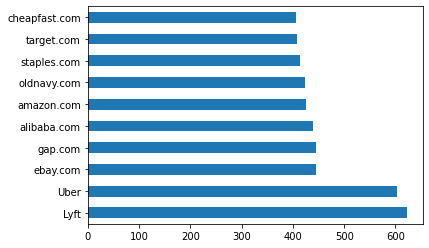

In [28]:
reversal_df.merchantName.value_counts()[:10].sort_values(ascending=False).plot(kind='barh')

<AxesSubplot:>

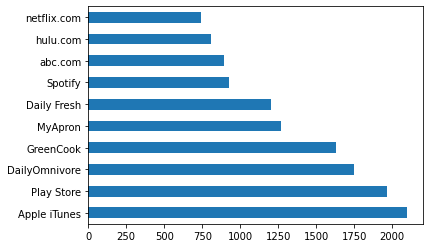

In [29]:
multi_swipes.merchantName.value_counts()[:10].sort_values(ascending=False).plot(kind='barh')

#### Obersvations 
Analyzing our reversal transactions we see that the most common kinds of transactions come from ride sharing services. Comparatively we see from our multiswipe transactions that the most common transactions are music and entertainment services. 

### Question 4

#### Model PreProcessing

In [30]:
model_data = df

In [31]:

model_data.drop([
         'cardLast4Digits',
         'accountOpenDate',
         'transactionDateTime',
         'currentExpDate',
         'customerId',
         'dateOfLastAddressChange',
         'accountNumber',
         'enteredCVV',
         'cardCVV',
         'merchantName'
         ], inplace=True, axis=1)

In [32]:
model_data.isnull().sum()

creditLimit                    0
availableMoney                 0
transactionAmount              0
acqCountry                  4562
merchantCountryCode          724
posEntryMode                4054
posConditionCode             409
merchantCategoryCode           0
transactionType              698
currentBalance                 0
cardPresent                    0
expirationDateKeyInMatch       0
isFraud                        0
dtype: int64

In [33]:
for features in ['cardPresent','expirationDateKeyInMatch','isFraud']:
    model_data[features] = model_data[features].replace({False:0,True:1})

In [34]:
y = model_data['isFraud']
model_data.drop('isFraud', inplace=True, axis=1)


#### One Hot Encoding

In [35]:
encoded_features = pd.get_dummies(model_data, columns=['merchantCountryCode',
      'merchantCategoryCode',
      'posConditionCode',
      'posEntryMode',
      'transactionType',
      'acqCountry']
)
encoded_features = encoded_features.replace(np.nan,0)

#### PLotting helper function

In [36]:
from sklearn.metrics import confusion_matrix
def plot_cm(classifier, predictions):
    cm = confusion_matrix(y_test, predictions)
    
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap='RdBu')
    classNames = ['Normal','Fraud']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), 
                     horizontalalignment='center', color='White')
    
    plt.show()
        
    tn, fp, fn, tp = cm.ravel()

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    F1 = 2*recall*precision/(recall+precision)

    print('Recall={0:0.3f}'.format(recall),'\nPrecision={0:0.3f}'.format(precision))
    print('F1={0:0.3f}'.format(F1))

    ### CITED FROM https://www.kaggle.com/code/andreanuzzo/balance-the-imbalanced-rf-and-xgboost-with-smote/notebook For Visualization and model reporting purposes.

### Data Augmentation Using Smote



Imbalanced classification can have an adverse impact on machine learning models as they will be more biased toward the majority class. After research my proposed solution to this problem is to utilize Synthetic Minority Oversampling Technique: or
SMOTE. Smote augments the data to synthetically create new data points for the minority class. (fraudulent transactions) Smote works by selecting instances that are close in feature space and then creating a line between the two instances
in the feature space and generating a new sample at a point on the line. As described by Nitesh Chawla, utilizing SMOTE in tandem with an undersampling technique has been shown to improve model performance. Drawing from this research I will utilize both SMOTE and a undersampling technique to help balance the class distributions


In [37]:
x_train, x_test, y_train, y_test = train_test_split(encoded_features, y,stratify = y,test_size = 0.25)


In [38]:
oversample  = SMOTE(sampling_strategy=0.55)
under_sample = RandomUnderSampler(sampling_strategy=0.4)
x_smote, y_smote = under_sample.fit_resample(x_train,y_train)
x_smote,y_smote = oversample.fit_resample(x_smote,y_smote)

In [39]:
y_smote.value_counts()

0    23282
1    12805
Name: isFraud, dtype: int64

### Model Selection and Comparison



For my model building I wanted to analyze the performance of XGBOOST, Randomforest, and a naive regression on flagging fraudulent transactions. XGBOOST is an ensemble method that builds trees sequentially.
Each tree built aims to reduce the errors of the previous tree, therefore each tree learns from the previous trees and updates residual errors. Furthermore it minimizes both regularizers (L1 and L2) to help reduce overfitting and uses a gradient descent algorithm to minimize the loss function. Comparatively random forest is a collection of decision trees. It utilizes bagging and random variable feature selection when building each decision tree to create a forest of trees whose prediction is made by a majority vote. Lastly I wanted to use a logistic regression algorithm to establish a baseline for model performance


## Models

### XGBOOST

In [41]:
scale_pos_wt = len(y_smote[y_smote == 0]) / sum(y_smote)

In [42]:
xgb_classifier = xgb.XGBClassifier(objective = 'binary:logistic' , missing = 0 , scale_pos_weight = scale_pos_wt ,n_jobs = -1,seed = 15)


In [43]:
xgb_classifier.fit(x_smote,
                y_smote,
                verbose = True,
                early_stopping_rounds= 10,
                eval_metric = 'auc',
                eval_set = [(x_test,y_test)]
                )

[0]	validation_0-auc:0.73632
[1]	validation_0-auc:0.74300


C:\Users\John Zhang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\John Zhang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[2]	validation_0-auc:0.75099
[3]	validation_0-auc:0.75197
[4]	validation_0-auc:0.75370
[5]	validation_0-auc:0.75652
[6]	validation_0-auc:0.75800
[7]	validation_0-auc:0.75977
[8]	validation_0-auc:0.76125
[9]	validation_0-auc:0.76182
[10]	validation_0-auc:0.76293
[11]	validation_0-auc:0.76319
[12]	validation_0-auc:0.76508
[13]	validation_0-auc:0.76571
[14]	validation_0-auc:0.76535
[15]	validation_0-auc:0.76578
[16]	validation_0-auc:0.76624
[17]	validation_0-auc:0.76794
[18]	validation_0-auc:0.77219
[19]	validation_0-auc:0.77318
[20]	validation_0-auc:0.77331
[21]	validation_0-auc:0.77350
[22]	validation_0-auc:0.77373
[23]	validation_0-auc:0.77425
[24]	validation_0-auc:0.77469
[25]	validation_0-auc:0.77505
[26]	validation_0-auc:0.77556
[27]	validation_0-auc:0.77596
[28]	validation_0-auc:0.77644
[29]	validation_0-auc:0.77624
[30]	validation_0-auc:0.77766
[31]	validation_0-auc:0.77741
[32]	validation_0-auc:0.77721
[33]	validation_0-auc:0.77716
[34]	validation_0-auc:0.77745
[35]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=0,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=15,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.8181960171807887,
              seed=15, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

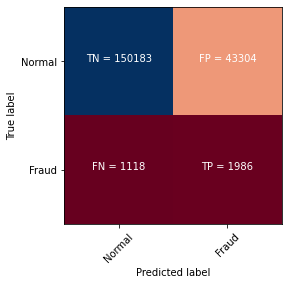

Recall=0.640 
Precision=0.044
F1=0.082


In [44]:
y_pred = xgb_classifier.predict(x_test)
plot_cm(y_test, y_pred)


In [45]:
from sklearn.metrics import accuracy_score
print('overall acuracy is ' , accuracy_score(y_test, y_pred), 'best auc score is ', xgb_classifier.best_score)


overall acuracy is  0.7740384859937637 best auc score is  0.779853


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

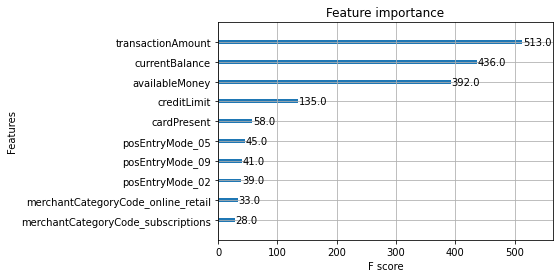

In [46]:
bst = xgb_classifier.get_booster()
from xgboost import plot_importance
plot_importance(xgb_classifier,max_num_features=10)

#### Feature Importance for XGBOOST

Shown above is the relative feature importance for our xgboost model

### Random Forest

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score as roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 

In [48]:
rand_f_clf=RandomForestClassifier(n_estimators=100,n_jobs = -1)
rand_f_clf.fit(x_smote,y_smote)

RandomForestClassifier(n_jobs=-1)

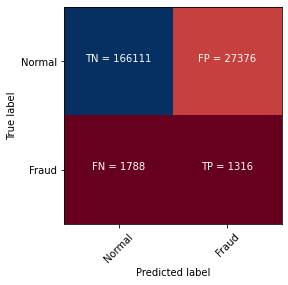

Recall=0.424 
Precision=0.046
F1=0.083
overall acuracy is  0.8516513980802783 best auc score is 0.7399492809701007


In [49]:
y_pred = rand_f_clf.predict(x_test)
plot_cm(y_test, y_pred)
print('overall acuracy is ' , accuracy_score(y_test, y_pred),'best auc score is', roc_auc_score(y_test, rand_f_clf.predict_proba(x_test)[:,1]) )

### Logistic Regression

In [50]:
from sklearn.linear_model import LogisticRegression

In [51]:

model = LogisticRegression(solver='liblinear')

In [52]:
model.fit(x_smote, y_smote)
y_pred_test = model.predict(x_test)

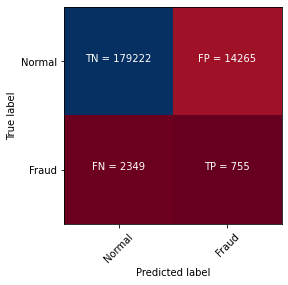

Recall=0.243 
Precision=0.050
F1=0.083
overall acuracy is  0.8516513980802783  best auc score is  0.7079638846577455


In [53]:

plot_cm(y_test, y_pred_test)
print('overall acuracy is ' , accuracy_score(y_test, y_pred), ' best auc score is ', roc_auc_score(y_test, model.decision_function(x_test)))


### Future Work and Model Hyperparameter Tuning First Attempt Lead To A Decrease In Performance

In [54]:
params = {
            'max_depth': [1, 3, 5],
            'learning_rate': [0.001, 0.01, 0.03, 0.05],
            'reg_alpha': [0.01, 0.05, 0.07, 0.09, 0.5, 1],
            'reg_lambda': [0.01, 0.05, 0.07, 0.09, 0.5, 1],
            'scale_pos_weight':[1,2,3,4,5,10,15,20,50]
        }

In [55]:

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(objective = 'binary:logistic'),
    param_grid=params,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 2,
    
    verbose=False
)

In [56]:
grid_search.fit(x_smote, y_smote)

C:\Users\John Zhang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\John Zhang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[15:49:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,...
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, v

C:\Users\John Zhang\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


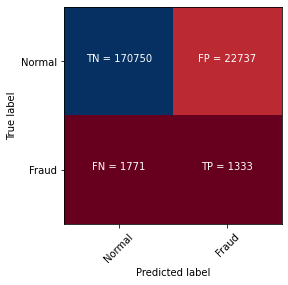

Recall=0.429 
Precision=0.055
F1=0.098
overall acuracy is  0.8753350865502489 best auc score is  0.779853


In [58]:
y_pred = grid_search.predict(x_test)
plot_cm(y_test, y_pred)
print('overall acuracy is ' , accuracy_score(y_test, y_pred), 'best auc score is ', xgb_classifier.best_score)

In [70]:
grid_search.best_params_

{'learning_rate': 0.05,
 'max_depth': 5,
 'reg_alpha': 1,
 'reg_lambda': 0.01,
 'scale_pos_weight': 1}

#### Second Attempt Did Not Work As My Computer Terminated

In [73]:
params = {
            'max_depth': [1, 3, 5,10,11],
            'learning_rate': [0.001, 0.05,0.06,0.08,0.09,0.1],
            'reg_alpha': [0.01, 0.05, 0.07, 0.09, 0.5, 1],
            'reg_lambda': [0.01, 0.05, 0.07, 0.09, 0.5, 1],
            'scale_pos_weight':[1,2,3,4,5,10,15,20,50]
        }

In [74]:

grid_search2 = GridSearchCV(
    estimator=xgb.XGBClassifier(objective = 'binary:logistic'),
    param_grid=params,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 2,
    verbose=False
)

In [ ]:
grid_search2.fit(x_smote, y_smote)